# 1D Least-Square Inversion of Airborne Frequency Domain Surveys

**Based on:** Notebook by Marco Couto

Workflow reviewed to open real data and run single sounding l2 inversion

## Importing libraries

In [4]:
# SimPEG functionality
import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Common Python functionality
import os
import numpy as np
import pandas as pd
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets
import dill
%matplotlib inline
mpl.rcParams.update({"font.size": 12})

## For the paralellization
import time
from multiprocessing import Pool

write_output = False  # Optional

## Useful functions

In [6]:
#Function to plot tikhonov curves

def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None):
    ### This function is from Lindseýs class (EOSC 454/556B - Winter 2024), quite helpful.

    """
    Plot Tikhonov curves to visualize the trade-offs between data misfit (phi_d) and model norms (phi_m) 
    across a range of regularization parameters (beta_values).

    This function creates three subplots: 
    1. beta_values vs phi_d
    2. beta_values vs phi_m
    3. phi_m vs phi_d
    If a target phi_d value (phid_star) is provided, it is plotted as a dashed line in the first and third subplots.
    Specific iterations can be highlighted with markers if provided.

    Parameters:
        beta_values (array-like): Array of regularization parameter values (beta).
        phi_d (array-like): Array of data misfit values corresponding to each beta.
        phi_m (array-like): Array of model norm values corresponding to each beta.
        phid_star (float, optional): Target value of data misfit to plot as a reference line. Defaults to None.
        iteration (int, optional): Index of a specific iteration to highlight in the plots. Defaults to None.
        ax (array of matplotlib.axes.Axes, optional): Pre-existing axes for the plot. If None, axes will be created.
        
    Returns:
        ax (array of matplotlib.axes.Axes): The array of matplotlib axes with the plots.

    Notes:
        This function is from Lindsey's class (EOSC 454/556B - Winter 2024), and is designed to be a helpful
        visual tool in understanding the balance between fitting the data and regularization.

    Examples:
        >>> beta_values = np.logspace(-3, 1, 50)
        >>> phi_d = 1 / beta_values
        >>> phi_m = beta_values ** 2
        >>> plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=0.1, iteration=25)
    """
    
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12,3))
    
    ax[0].plot(beta_values, phi_d)
    ax[1].plot(beta_values, phi_m)
    ax[2].plot(phi_m, phi_d)

    if phid_star is not None: 
        ax[0].plot(beta_values, np.ones_like(beta_values) * phid_star, "--k")
        ax[2].plot(phi_m, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].loglog(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].loglog(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].loglog(phi_m[iteration], phi_d[iteration], "C3o")

    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()
    
    return ax

#Function to plot geographical trasmitter location
def plot_survey_lines(fdem_data, line_no, return_results=True, plot_results=True):
    """
    Plot the geographical distribution of transmitter locations for a specific survey line within a dataset.

    This function takes a line number, groups the data by line, and plots the transmitter locations for
    all lines in a faint scatter plot and highlights the transmitter locations for the specified line in a
    more pronounced scatter plot. The figure's axes are labeled with easting and northing in meters.

    Parameters:
        line_no (int or str): Identifier for the survey line whose data is to be plotted.
        display_results (bool, optional): If True, the function returns the data frame and station
                                          identifiers for the specified line. Defaults to False.

    Returns:
        tuple: Only if display_results is True. Returns a tuple containing:
               - pandas.DataFrame: Data frame for the specified line.
               - numpy.ndarray: Array of station identifiers for the specified line based on the fiducial code.

    Notes:
        This function assumes the existence of a globally accessible pandas DataFrame named `fdem_data` with
        at least the following columns: ['Line', 'fid', 'x_tx', 'y_tx']. It also assumes that the data has
        already been loaded and is available for processing.

    Examples:
        >>> plot_line_survey(101)
        >>> line_data, stations = plot_line_survey(101, display_results=True)
    """
    
    line_grouping = fdem_data.groupby('Line')
    line = line_grouping.get_group(line_no)
    line_stations = line.fid.values

    if plot_results:
        fig, ax = plt.subplots(figsize=(6, 6))        
        ax.scatter(fdem_data.x_tx, fdem_data.y_tx, s=0.5)
        ax.scatter(line.x_tx, line.y_tx, s=0.5)
        ax.set_xlabel('Easting (m)')
        ax.set_ylabel('Northing (m)')
        ax.ticklabel_format(axis='both', style='sci', scilimits=(6,5))
        ax.set_title(line_no)
        plt.tight_layout()

    if return_results:
        return line, line_stations

#Plot line of data
def plot_station_line_data(line, line_no, fid_list, freqs=[None], freqs_names=[None], display_results=False, plot_coaxial=False, plot_results=True):
    """
    Plot data for a specific survey station on a given line, including the geographical plot of the
    flight line and sounding data. This function creates several visualizations to analyze the frequency response
    at a specific station compared to the entire flight line data.

    Parameters:
        line_no (int or str): Identifier for the survey line whose data is to be plotted.
        fid (int or str): Identifier for the specific station (fiducial) on the flight line to highlight.
        display_results (bool, optional): If True, returns detailed data arrays for the specific station. Defaults to False.

    Returns:
        tuple: Only if display_results is True. Returns a tuple containing:
               - pandas.DataFrame: Data frame for the specific station.
               - int or str: Fiducial identifier.
               - list: In-phase data for the specific station across all frequencies.
               - list: Quadrature data for the specific station across all frequencies.

    Notes:
        Assumes availability of a globally accessible pandas DataFrame `fdem_data` with columns including 'Line', 'fid', 'x_tx', 'y_tx',
        and data fields formatted as 'cxi{frequency}' or 'cpi{frequency}' for in-phase data and 'cxq{frequency}' or 'cpq{frequency}'
        for quadrature data. The 'freqs' variable should be an iterable containing the frequency labels used in the data fields.
        This function also uses 'all_freqs_num', which should be the numerical values of frequencies for plotting.

    Examples:
        >>> plot_station_line_data(101, 205)
        >>> station_data, station_fid, inphase_data, quad_data = plot_station_line_data(101, 205, display_results=True)
    """


    #choose current line
    line_grouping = fdem_data.groupby('Line')
    line = line_grouping.get_group(line_no)

    #choose list of stations
    filtered_line = line[line["fid"].isin(fid_list)]
    
    # Select only numeric columns for mean calculation
    numeric_filtered_line = filtered_line.select_dtypes(include=["number"])
    
    # Group by 'fid' and calculate the mean for numeric columns only
    line_station = numeric_filtered_line.groupby("fid", as_index=False).mean()


    ### Getting the data for the sounding point and the data for the whole line
    inphase_station_data = []
    quad_station_data = []
    inphase_line_data = []
    quad_line_data = []


    for f in freqs_names:
        if plot_coaxial == True:
            inphase_station_data.append(line_station[f'cxi{f}'])
            quad_station_data.append(line_station[f'cxq{f}'])
            nphase_line_data.append(line[f'cxi{f}'])
            quad_line_data.append(line[f'cxq{f}'])
        else:
            inphase_station_data.append(line_station[f'cpi{f}'])
            quad_station_data.append(line_station[f'cpq{f}'])
            inphase_line_data.append(line_station[f'cpi{f}'])
            quad_line_data.append(line_station[f'cpq{f}'])

    inphase_station_data = np.array(inphase_station_data)
    quad_station_data = np.array(quad_station_data)
    inphase_line_data = np.array(inphase_line_data)
    quad_line_data = np.array(quad_line_data)
    
    if plot_results:

        ### Sounding plot
        fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    
        ax[0].scatter(line.x_tx, line.y_tx, s=0.5)
        #if fid in line.fid.values:
        for i,fid in enumerate(fid_list):
            ax[0].scatter(line_station[line_station.fid == fid].x_tx, line_station[line_station.fid == fid].y_tx, s=40, marker='o', label = line_station[line_station.fid == fid].fid.values)
            ax[1].loglog(freqs, inphase_station_data[:,i], "-o", lw=2, label = line_station[line_station.fid == fid].fid.values)
            ax[1].loglog(freqs, quad_station_data[:,i], ":o", lw=2, label = line_station[line_station.fid == fid].fid.values)
        ax[0].set_xlabel('Easting (m)')
        ax[0].set_ylabel('Northing (m)')
        ax[0].ticklabel_format(style='sci')
        ax[0].set_title('Flight Line')
        ax[0].ticklabel_format(axis='both', style='sci', scilimits=(6,5))
        ax[0].legend()
    
        ax[1].grid(which="both")
        ax[1].set_xlabel("Frequency (Hz)")
        ax[1].set_ylabel("|Hs/Hp| (ppm)")
        ax[1].set_title("Sounding Data")
        ax[1].legend(["Real", "Imaginary"])
    
        fig.suptitle(f'{line_no} - Fiducial: {fid}', fontsize=14)
        plt.tight_layout()
        plt.show()

        ### Profile plot
        fig, ax = plt.subplots(2, 1, figsize=(9, 6))
        for i, f in enumerate(freqs):
            ax[0].semilogy(line_station.dist, inphase_line_data[i, :], "-o", lw=1, label = f"{freqs_names[i]}")
            ax[1].semilogy(line_station.dist, quad_line_data[i, :], "-o",  lw=1, label = f"{freqs_names[i]}")
        
        for i,fid in enumerate(fid_list):
            ax[0].axvline(line_station[line_station.fid == fid].dist.values[0], linestyle='--')
            #ax[0].text(line_station[line_station.fid == fid].dist.values[0], 0.1, line_station[line_station.fid == fid].fid.values, ha='center', va='bottom', color='black', fontsize=10)
            
            ax[1].axvline(line_station[line_station.fid == fid].dist.values[0], linestyle='--')
            #ax[1].text(line_station[line_station.fid == fid].dist.values[0], 0.1, line_station[line_station.fid == fid].fid.values, ha='center', va='bottom', color='black', fontsize=10)
            
        ax[1].set_xlabel("Profile Distance (m)")
        ax[0].set_ylabel("|Hs/Hp| (ppm)")
        ax[1].set_ylabel("|Hs/Hp| (ppm)")
        ax[0].legend()
        ax[1].legend()
        ax[0].set_title("Real")
        ax[1].set_title("Imaginary")
        ax[0].grid(which="both", linestyle="--", color='gray')
        ax[1].grid(which="both", linestyle="--", color='gray')
    
        # fig.suptitle(f'{line_no} - Fiducial: {fid}', fontsize=14)
        plt.tight_layout()
        plt.show()
        
    if display_results:
        return line_station, fid, inphase_station_data, quad_station_data

#Calculate the coordinates of transmitter and receiver
def calculate_tx_rx_coordinates(line, plot_histogram=False):
    """
    Calculates the transmitter (Tx) and receiver (Rx) coordinates for various frequencies
    based on azimuth values from the input dataframe.
    
    Parameters:
    - line (pd.DataFrame): Input dataframe containing x_tx and y_tx columns.
    - plot_histogram (bool): Whether to plot a histogram of azimuth values. Default is False.
    
    Returns:
    - pd.DataFrame: Updated dataframe with calculated Tx and Rx coordinates.
    """
    theta = []  # To store the co-azimuth in radians
    Az_rad = []  # To store the azimuth values in radians

    # Dictionary with Tx-Rx coil separation
    d = {
        'cp140k': 7.95,
        'cp40k': 7.93,
        'cp8200': 7.95,
        'cx3300': 9.06,
        'cp1800': 7.94,
        'cp400': 7.93
    }

    # Initialize arrays for Tx and Rx coordinates
    num_points = line.x_tx.values.shape[0]
    coords = {f"{key}_{suffix}": np.zeros(num_points) for key in d for suffix in ["tx_x", "tx_y", "rx_x", "rx_y"]}

    # Calculate coordinates based on azimuth
    for i in range(num_points - 1):
        deltay = line.y_tx.values[i + 1] - line.y_tx.values[i]
        deltax = line.x_tx.values[i + 1] - line.x_tx.values[i]
        # angle = np.arctan2(deltay, deltax)
        angle = np.arctan(deltay / deltax)
        theta.append(angle)
        # print(f'angle = {angle}')
        Az_rad.append(angle if angle >= 0 else 2 * np.pi + angle)

        for key, dist in d.items():
            dx = (dist / 2) * np.sin(angle)
            dy = (dist / 2) * np.cos(angle)

            coords[f"{key}_tx_x"][i] = line.x_tx.values[i] + dx
            coords[f"{key}_tx_y"][i] = line.y_tx.values[i] + dy
            coords[f"{key}_rx_x"][i] = line.x_tx.values[i] - dx
            coords[f"{key}_rx_y"][i] = line.y_tx.values[i] - dy

    Az_rad = np.array(Az_rad)
    Az_deg = Az_rad * 180 / np.pi

    if plot_histogram:
        plt.hist(Az_deg, bins=100)
        plt.title("Azimuth Distribution (Degrees)")
        plt.xlabel("Azimuth (degrees)")
        plt.ylabel("Frequency")
        plt.show()

        print(f'Mean azimuth: {np.mean(Az_deg):.2f} degrees')
        print(f'Std azimuth: {np.std(Az_deg):.2f} degrees')
        print('-----------------------------------\n')

    # Assign calculated Tx-Rx coordinates to the dataframe
    for key, values in coords.items():
        line[key] = values

    return line

#Calculate cumulative distances
def calculate_cumulative_distance(df, x_col='X', y_col='Y'):
    """
    Calculate the cumulative distance from the first point in a profile.

    Parameters:
    df (pd.DataFrame): The dataframe containing the X and Y coordinates.
    x_col (str): The name of the column containing the X coordinates. Default is 'X'.
    y_col (str): The name of the column containing the Y coordinates. Default is 'Y'.

    Returns:
    pd.DataFrame: The input dataframe with an additional column 'dist' containing the cumulative distances.
    """
    # Extract the X and Y coordinates
    x = df[x_col].values
    y = df[y_col].values
    
    # Calculate the differences between consecutive points
    dx = np.diff(x)
    dy = np.diff(y)
    
    # Calculate the Euclidean distance between consecutive points
    distances = np.sqrt(dx**2 + dy**2)
    
    # Prepend a 0 to the distances array to represent the distance from the first point to itself
    distances = np.insert(distances, 0, 0)
    
    # Calculate the cumulative distance
    cumulative_distances = np.cumsum(distances)
    
    # Add the cumulative distances to the dataframe
    df['dist'] = cumulative_distances
    
    return df

def make_directory(directory_name, absolute_path=False):
    """
    Checks if a directory exists one level above the current working directory.
    If it does not exist, the directory is created.

    :param directory_name: Name of the directory to check or create.
    :return: The relative path to the directory (e.g., "../my_directory").
    """
    # Get the current working directory
    work_directory = os.getcwd()

    # Get the parent directory (one level above)
    parent_directory = os.path.dirname(work_directory)

    # Create the full path for the directory
    directory_path = os.path.join(parent_directory, directory_name)

    # Check if the directory exists
    if not os.path.exists(directory_path):
        # Create the directory if it does not exist
        os.makedirs(directory_path)
        print(f"Directory '{directory_name}' created in '{parent_directory}'.")
    else:
        print(f"Directory '{directory_name}' already exists in '{parent_directory}'.")


    if absolute_path:
        # Return the absolute path (e.g., "/home/user/my_directory")
        return directory_path
    else:
        # Return the relative path (e.g., "../my_directory")
        return f"../{directory_name}"

## Inversion function

* Reading the data
* Defining Sources and Receivers
* Defining the data
* Halfspace inversion, pick 3 soundings, use this as reference model
* Inversion with Least Squares

## Importing the data

* Importing the data from database

In [9]:
data_dir = '../database/'

csv_files = []
csv_titles = []
extension = "csv"

for root, dirs, files in os.walk(data_dir, topdown=False):
    for f in files:
        if f.split(".")[-1].upper() == extension.upper():
            csv_titles.append(f.split(".")[-2])
            csv_files.append(os.path.join(root, f))

csv_files

[]

Read data from csv: 

In [11]:
import os

# Get the current working directory (where the notebook is running)
current_dir = os.getcwd()

# Move one level up to the parent directory
parent_dir = os.path.dirname(current_dir)

# Construct the full path to the CSV file in the parent directory
csv_path = os.path.join(parent_dir, "block53_fdem_inv.csv")

fdem_data = pd.read_csv(csv_path) ## Set to the position of the csv_files list where the database you want is
pd.set_option('display.max_columns', len(fdem_data.columns))
fdem_data.head()

/var/folders/gb/v44v1_q914718nzwmm90d6pr0000gn/T/ipykernel_78288/424418050.py:12: DtypeWarning: Columns (80,86,87,311,312) have mixed types. Specify dtype option on import or set low_memory=False.
  fdem_data = pd.read_csv(csv_path) ## Set to the position of the csv_files list where the database you want is


,x_tx,y_tx,gpsz_tx,altlas_bird,altlas_bird_derot,altrad_heli,bird_pitch,bird_roll,bird_yaw,Block,cp40k_reim,cp140k_reim,cp400_reim,cp1800_reim,cp8200_reim,cpi40k,cpi140k,cpi400,cpi1800,cpi8200,cpq40k,cpq140k,cpq400,cpq1800,cpq8200,cpsp,cx3300_reim,cxi3300,cxq3300,cxsp,date,ddep40k,ddep140k,ddep400,ddep1800,ddep8200,dep40k,dep140k,dep400,dep1800,dep8200,diurnal,diurnal_cor,dtm,fid,flight,gpsz_heli,igrf,lat_heli,lat_tx,Line,line(1),long_heli,long_tx,mag_diu,mag_lag,mag_rmi,mag_rmi analytic signal,mag_rmi hd filtered,mag_rmi rtp filtered,mag_rmi tilt angle,mag_rmi vd filtered,mag_rmi_HDX,mag_rmi_HDY,mag_tmi,powerline,res40k,res140k,res400,res1800,res8200,time_ssm,x_heli,y_heli,iter,beta,phi_d,phi_m,f,n_layers,resistivies,resistivity_hsp,phi_d_star,chi_factor,rms,doi_CA2012,Sj_star_CA2012,S_CA2012,rho01,rho02,rho03,rho04,rho05,rho06,rho07,rho08,rho09,rho10,rho11,rho12,rho13,rho14,rho15,rho16,rho17,rho18,rho19,rho20,rho21,rho22,rho23,rho24,rho25,rho26,rho27,rho28,rho29,rho30,rho31,rho32,rho33,rho34,rho35,rho36,rho37,rho38,rho39,rho40,thick01,thick02,thick03,thick04,thick05,thick06,thick07,thick08,thick09,thick10,thick11,thick12,thick13,thick14,thick15,thick16,thick17,thick18,thick19,thick20,thick21,thick22,thick23,thick24,thick25,thick26,thick27,thick28,thick29,thick30,thick31,thick32,thick33,thick34,thick35,thick36,thick37,thick38,thick39,dpred_cpi140k,dpred_cpq140k,dpred_cpi40k,dpred_cpq40k,dpred_cpi8200,dpred_cpq8200,dpred_cpi1800,dpred_cpq1800,dpred_cpi400,dpred_cpq400,dobs_cpi140k,dobs_cpq140k,dobs_cpi40k,dobs_cpq40k,dobs_cpi8200,dobs_cpq8200,dobs_cpi1800,dobs_cpq1800,dobs_cpi400,dobs_cpq400,rho_halfspace,rho01_mref1,rho02_mref1,rho03_mref1,rho04_mref1,rho05_mref1,rho06_mref1,rho07_mref1,rho08_mref1,rho09_mref1,rho10_mref1,rho11_mref1,rho12_mref1,rho13_mref1,rho14_mref1,rho15_mref1,rho16_mref1,rho17_mref1,rho18_mref1,rho19_mref1,rho20_mref1,rho21_mref1,rho22_mref1,rho23_mref1,rho24_mref1,rho25_mref1,rho26_mref1,rho27_mref1,rho28_mref1,rho29_mref1,rho30_mref1,rho31_mref1,rho32_mref1,rho33_mref1,rho34_mref1,rho35_mref1,rho36_mref1,rho37_mref1,rho38_mref1,rho39_mref1,rho40_mref1,rho_hsp_mref1,rho01_mref2,rho02_mref2,rho03_mref2,rho04_mref2,rho05_mref2,rho06_mref2,rho07_mref2,rho08_mref2,rho09_mref2,rho10_mref2,rho11_mref2,rho12_mref2,rho13_mref2,rho14_mref2,rho15_mref2,rho16_mref2,rho17_mref2,rho18_mref2,rho19_mref2,rho20_mref2,rho21_mref2,rho22_mref2,rho23_mref2,rho24_mref2,rho25_mref2,rho26_mref2,rho27_mref2,rho28_mref2,rho29_mref2,rho30_mref2,rho31_mref2,rho32_mref2,rho33_mref2,rho34_mref2,rho35_mref2,rho36_mref2,rho37_mref2,rho38_mref2,rho39_mref2,rho40_mref2,rho_hsp_mref2,doi_index_layer01,doi_index_layer02,doi_index_layer03,doi_index_layer04,doi_index_layer05,doi_index_layer06,doi_index_layer07,doi_index_layer08,doi_index_layer09,doi_index_layer10,doi_index_layer11,doi_index_layer12,doi_index_layer13,doi_index_layer14,doi_index_layer15,doi_index_layer16,doi_index_layer17,doi_index_layer18,doi_index_layer19,doi_index_layer20,doi_index_layer21,doi_index_layer22,doi_index_layer23,doi_index_layer24,doi_index_layer25,doi_index_layer26,doi_index_layer27,doi_index_layer28,doi_index_layer29,doi_index_layer30,doi_index_layer31,doi_index_layer32,doi_index_layer33,doi_index_layer34,doi_index_layer35,doi_index_layer36,doi_index_layer37,doi_index_layer38,doi_index_layer39,doi_index_layer40,dist,depths,alts,depth01,alt01,depth02,alt02,depth03,alt03,depth04,alt04,depth05,alt05,depth06,alt06,depth07,alt07,depth08,alt08,depth09,alt09,depth10,alt10,depth11,alt11,depth12,alt12,depth13,alt13,depth14,alt14,depth15,alt15,depth16,alt16,depth17,alt17,depth18,alt18,depth19,alt19,depth20,alt20,depth21,alt21,depth22,alt22,depth23,alt23,depth24,alt24,depth25,alt25,depth26,alt26,depth27,alt27,depth28,alt28,depth29,alt29,depth30,alt30,depth31,alt31,depth32,alt32,depth33,alt33,depth34,alt34,depth35,alt35,depth36,alt36,depth37,alt37,depth38,alt38,depth39,alt39,depth40,alt40,depth41,alt41,doi_OL1999,doi_alt_OL1999,doi_alt_CA2012,x,y,z,layer,rho
0,553008.70

In [12]:
fdem_data.rename(columns={'X': 'x_tx', 'Y':'y_tx', 'Z':'gpsz_tx'}, inplace=True) ## Change the name of the coordinates columns here, if needed:
np.array(fdem_data.columns) ## Shows all the columns names inside the dataframe

array(['x_tx', 'y_tx', 'gpsz_tx', 'altlas_bird', 'altlas_bird_derot',
       'altrad_heli', 'bird_pitch', 'bird_roll', 'bird_yaw', 'Block',
       'cp40k_reim', 'cp140k_reim', 'cp400_reim', 'cp1800_reim',
       'cp8200_reim', 'cpi40k', 'cpi140k', 'cpi400', 'cpi1800', 'cpi8200',
       'cpq40k', 'cpq140k', 'cpq400', 'cpq1800', 'cpq8200', 'cpsp',
       'cx3300_reim', 'cxi3300', 'cxq3300', 'cxsp', 'date', 'ddep40k',
       'ddep140k', 'ddep400', 'ddep1800', 'ddep8200', 'dep40k', 'dep140k',
       'dep400', 'dep1800', 'dep8200', 'diurnal', 'diurnal_cor', 'dtm',
       'fid', 'flight', 'gpsz_heli', 'igrf', 'lat_heli', 'lat_tx', 'Line',
       'line(1)', 'long_heli', 'long_tx', 'mag_diu', 'mag_lag', 'mag_rmi',
       'mag_rmi analytic signal', 'mag_rmi hd filtered',
       'mag_rmi rtp filtered', 'mag_rmi tilt angle',
       'mag_rmi vd filtered', 'mag_rmi_HDX', 'mag_rmi_HDY', 'mag_tmi',
       'powerline', 'res40k', 'res140k', 'res400', 'res1800', 'res8200',
       'time_ssm', 'x_heli', '

## Defining the system parameters

### System Frequencies

We define the system frequencies below:

In [16]:
all_freqs_num = np.r_[135, 40, 8.2, 3.3, 1.8, 0.4]*1e3 ## Creates a numpy array with all frequencies
all_freqs_num[::-1].sort()
all_freqs_num

array([135000.,  40000.,   8200.,   3300.,   1800.,    400.])

If you don`t want to invert coaxial frequencies, define them below: ?

In [18]:
freq_cx = [3300] ## Coaxial frequencies - numpy array
all_freqs_num = np.delete(all_freqs_num, np.where(all_freqs_num == freq_cx)) ## Removes the coaxial frequencies from the list
all_freqs_num

array([135000.,  40000.,   8200.,   1800.,    400.])

Creating a list with the frequencies in string format too:

In [20]:
all_freqs = ['140k', '40k', '8200', '3300', '1800', '400'] ## All frequencies
freq_cx_str = ['3300'] ## Coaxial frequencies - string array
all_freqs = np.array([f for f in all_freqs if f not in freq_cx_str]) ## Removes the coaxial frequencies from the list
all_freqs

array(['140k', '40k', '8200', '1800', '400'], dtype='<U4')

### System geometry and physical parameters

In [22]:
## Source orientation
source_orientation = ["z", "z", "z", "z", "z"] # "x", "y" or "z" - here we are using only the CP frequencies
moments = [17, 49, 72, 187, 359]  ## Tx dipole moments fromm Xcalibur´s report -  only cp geometry

## Receiver orientation
receiver_orientation = ["z", "z", "z", "z", "z"]  # "x", "y" or "z" - here we are using only the CP frequencies
data_type = 'ppm'  # "secondary", "total" or "ppm"

## Defining inversion parameters and testing on a specific sounding

In [24]:
ipywidgets.interact(
    plot_survey_lines,
    fdem_data = ipywidgets.fixed(fdem_data),
    line_no = ipywidgets.SelectionSlider(
            options=fdem_data.Line.values,
            value=fdem_data.Line.values[0],
            description='Line: ',
            # disabled=False,
            # continuous_update=False,
            # orientation='horizontal',
            # readout=True
        ),
    return_results = ipywidgets.fixed(False),
    plot_resutls = ipywidgets.fixed(True)

)

interactive(children=(SelectionSlider(description='Line: ', options=('L530030', 'L530030', 'L530030', 'L530030…

<function __main__.plot_survey_lines(fdem_data, line_no, return_results=True, plot_results=True)>

# Plotting Line data

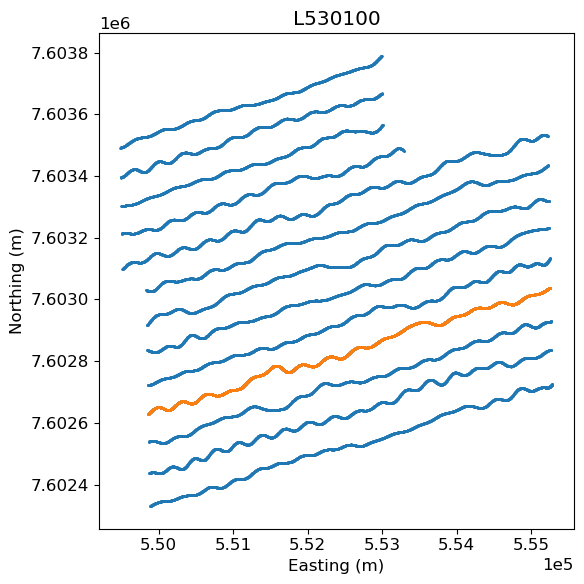

In [26]:
line_no = 'L530100' ### "regular" flight line
lines = fdem_data['Line'].unique()
line, line_fids = plot_survey_lines(fdem_data, line_no, return_results=True, plot_results=True) ## Plots the map with the selected line for confirmation

/var/folders/gb/v44v1_q914718nzwmm90d6pr0000gn/T/ipykernel_78288/1963457136.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  line_station = numeric_filtered_line.groupby("fid", as_index=False).mean()


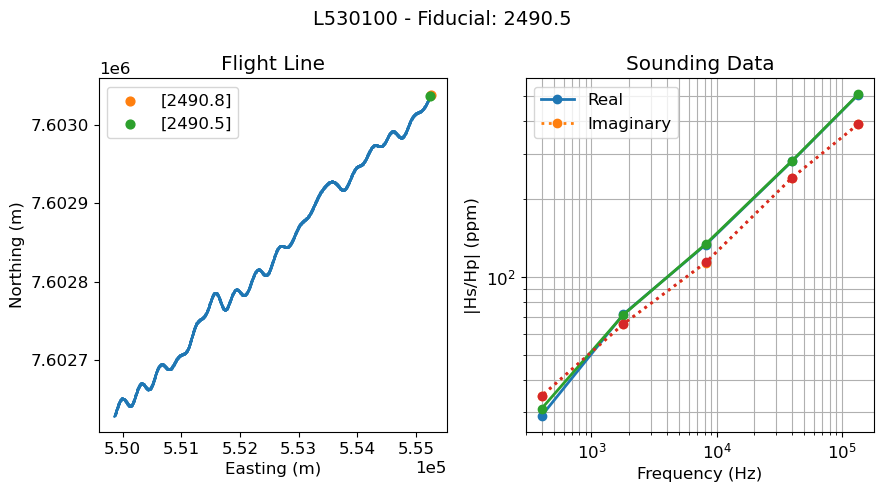

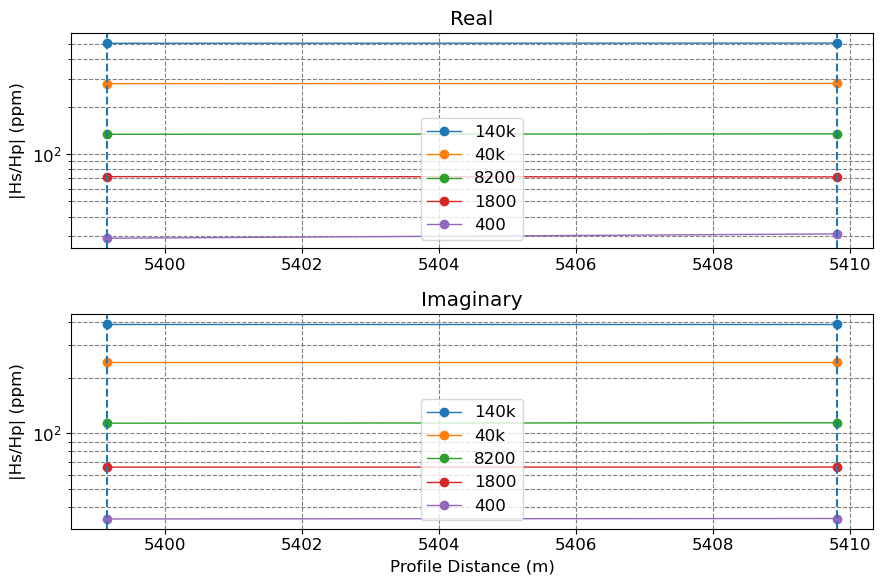

In [27]:
plot_station_line_data(fdem_data, line_no, [2490.8, 2490.5], freqs = all_freqs_num, freqs_names=all_freqs, display_results=False, plot_results=True)

# Choose the soundings

/var/folders/gb/v44v1_q914718nzwmm90d6pr0000gn/T/ipykernel_78288/1963457136.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  line_station = numeric_filtered_line.groupby("fid", as_index=False).mean()


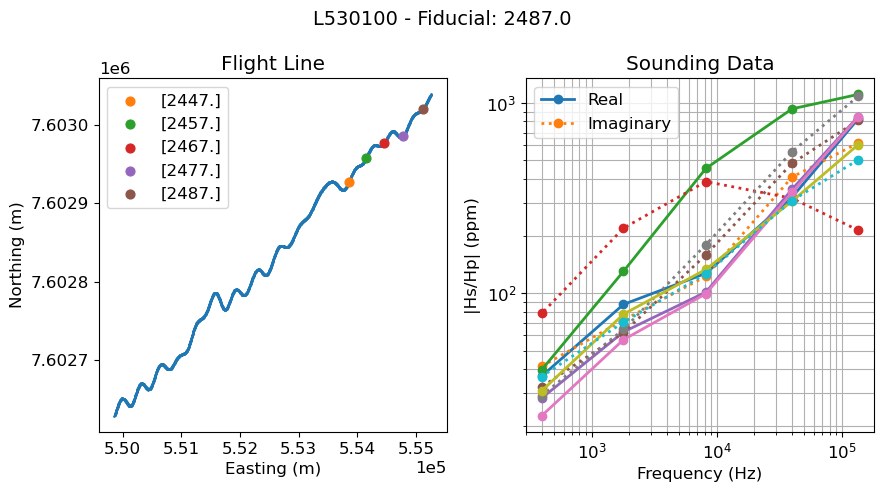

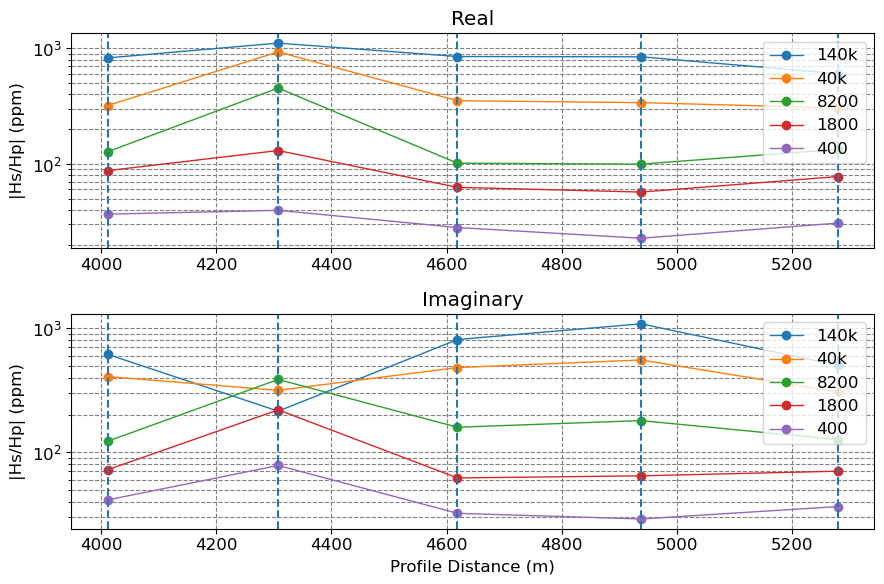

In [29]:
line_grouping = fdem_data.groupby('Line')
line = line_grouping.get_group(line_no)

#Find all not nan fid values:
non_nan_fid = line[line['fid'].notna()]['fid'].values

#choose every 200 sounding of the last part 
list_fid = (non_nan_fid[3000:])[::100]


plot_station_line_data(fdem_data, line_no, list_fid, freqs = all_freqs_num, freqs_names=all_freqs, display_results=False, plot_results=True)

# Running the inversion for one sounding point

In [31]:
line_no = 'L530100'
fid_n = 2457.0

#line = fdem_data.loc[(fdem_data['Line'] == line_no)]

line = fdem_data.loc[fdem_data['Line'] == line_no].copy()
line = calculate_tx_rx_coordinates(line)

#choose a single fid: from line
line_station = line.loc[line.fid == fid_n].iloc[0]

#Calculate the coordinates
#line_station = calculate_tx_rx_coordinates(line_station)


## Defining source and receiver data objects

In [33]:
# Define inversion: parameters:
freq = all_freqs_num
freqs = all_freqs_num
freqs_names = all_freqs
freq_avoid = [400., 1800., 8200.]
rm_real=True
rm_imag=True


#Define the Source orientation 
tx_orient = ["z", "z", "z", "z", "z"]
moments = [17, 49, 72, 187, 359]

# Define receiver orientation and type
rx_orient = ["z", "z", "z", "z", "z"] 
dtype = "ppm"

#Calculate the height (terrain clearance)
line_station.loc['height_tx'] = line_station['gpsz_tx'] - line_station['dtm']

######################################
### Defining Sources and Receivers ###
######################################

# Generate the labels with frequency values strings
source_locations = np.array([[
            getattr(line_station, f'cp{freq}_tx_x'),  # Transmitter X
            getattr(line_station, f'cp{freq}_tx_y'),  # Transmitter Y
            getattr(line_station, 'height_tx')  # Common height for the transmitter
            ] for freq in all_freqs])

receiver_locations = np.array([[
            getattr(line_station, f'cp{freq}_rx_x'),  # Transmitter X
            getattr(line_station, f'cp{freq}_rx_y'),  # Transmitter Y
            getattr(line_station, 'height_tx')  # Common height for the transmitter
            ] for freq in all_freqs])


#Create source and receiver list
source_list = []

for i, freq in enumerate(freqs):
 
    receiver_list = []

    #Add real readings
    if rm_real:
        if freq not in freq_avoid:
            receiver_list.append(
                fdem.receivers.PointMagneticFieldSecondary(
                    locations=np.c_[receiver_locations[i]].T,
                    orientation=rx_orient[i],
                    data_type=dtype,
                    component="real",
                )
            )
    else:
        receiver_list.append(
            fdem.receivers.PointMagneticFieldSecondary(
                locations=np.c_[receiver_locations[i]].T,
                orientation=rx_orient[i],
                data_type=dtype,
                component="real",
            )
        )
    if rm_imag:
            if freq not in freq_avoid:
                receiver_list.append(
                    fdem.receivers.PointMagneticFieldSecondary(
                        locations=np.c_[receiver_locations[i]].T,
                        orientation=rx_orient[i],
                        data_type=dtype,
                        component="imag",
                    )
                )
    else:
        receiver_list.append(
            fdem.receivers.PointMagneticFieldSecondary(
                locations=np.c_[receiver_locations[i]].T,
                orientation=rx_orient[i],
                data_type=dtype,
                component="imag",
            )
        )

    #Apprend source
    source_list.append(
            fdem.sources.MagDipole(
                receiver_list=receiver_list,
                frequency=freq,
                location=np.c_[source_locations[i]].T,
                orientation=tx_orient[i],
                moment=moments[i],
            )
        )

#########################
### Defining the data ###
#########################

## Defines the survey object
survey = fdem.survey.Survey(source_list)
survey.nD ## Check the number of Tx and Rx components (Real and Imaginary) - it should be 2 * the number of used frequencies

# Get arrays of data from sounding
inphase_data = []
quad_data = []

for f in freqs_names:
    inphase_data.append(line_station[f'cpi{f}'])
    quad_data.append(line_station[f'cpq{f}'])

inphase_data = np.array(inphase_data)
quad_data = np.array(quad_data)


#get rid of frequencies to avoid:
if rm_real and rm_imag:
    ind_avoid = [np.where(all_freqs_num == f)[0][0] for f in freq_avoid]
elif rm_real:
    ind_avoid = [np.where(all_freqs_num == f)[0][0] for f in freq_avoid]
elif rm_imag:
    ind_avoid = [np.where(all_freqs_num == f)[0][0] for f in freq_avoid]
else:
    ind_avoid = [None]

#Put everything in a single array

dobs = []
for i in range(len(inphase_data)):

    # if i == 3: ## In this analysis, we are not inverting the coaxial data
    #     pass
    # else:
    if rm_real and not rm_imag:
        if i not in ind_avoid:
            dobs = np.append(dobs, inphase_data[i])
        dobs = np.append(dobs, quad_data[i])
    elif rm_imag and not rm_real:
        dobs = np.append(dobs, inphase_data[i])
        if i not in ind_avoid:
            dobs = np.append(dobs, quad_data[i])
    elif rm_real and rm_imag:
        if i not in ind_avoid:
            dobs = np.append(dobs, inphase_data[i])
            dobs = np.append(dobs, quad_data[i])
    else:
        dobs = np.append(dobs, inphase_data[i])
        dobs = np.append(dobs, quad_data[i])


#Create data simpeg object:

# Defines the data object and assigns uncertainties with the noise floor
uncertainty_floor = 5.0e0
relative_error = 0.05 #What is relative error?
data_object = data.Data(survey, dobs=dobs, relative_error=relative_error, noise_floor=uncertainty_floor)


# Halspace Inversion

In [35]:
### Mesh Definition for halfspace ###

layer_thick_halfspace = [10000]
n_layers_halfspace = 1

# Defining the mapping
log_conductivity_halfspace_map = maps.ExpMap(nP=n_layers_halfspace)

# Starting model is log-conductivity values (S/m)
starting_conductivity_model_hsp = np.log(1e-3 * np.ones(n_layers_halfspace))

# Reference model, same as starting 
reference_conductivity_model_hsp = starting_conductivity_model_hsp.copy()

### Forward simulation ###

simulation_hsp_L2 = fdem.Simulation1DLayered(
        survey=survey,
        thicknesses=[],
        sigmaMap=log_conductivity_halfspace_map
    )

### Data Misfit ###

dmis_hsp_L2 = data_misfit.L2DataMisfit(simulation=simulation_hsp_L2, data=data_object)

### Regularization ###

h = np.r_[layer_thick_halfspace]

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")

reg_L2 = regularization.WeightedLeastSquares(
        regularization_mesh,
        length_scale_x=10.0,
        # reference_model=np.r_[reference_conductivity_model, reference_conductivity_model[-1]],
        reference_model=reference_conductivity_model_hsp,
        reference_model_in_smooth=False
        )

#Set regularization parameters:
reg_L2.alpha_s = 1e-5 
reg_L2.alpha_x=1 

### Optimization ###
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Inversion ###
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_hsp_L2, reg_L2, opt_L2)

#Set inversion directives:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=1.5, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_L2_hp = directives.SaveOutputDictEveryIteration()

directives_list_L2 = [
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_L2_hp
]

### Running the inversion ###
# Combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# print(f"\n **** Running halfspace inversion for line {line_no} and station {stn}... ****")
recovered_halfspace_model_L2 = inv_L2.run(starting_conductivity_model_hsp)

## Get the recovered halfspace resistivity from model estimated
conductivities_hsp = log_conductivity_halfspace_map * recovered_halfspace_model_L2
resistivities_hsp = 1 / conductivities_hsp




Running inversion with SimPEG v0.23.1.dev1+g60e0c3a5

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.98e+03  6.60e+02  0.00e+00  6.60e+02    1.71e+02      0              
   1  5.98e+03  6.40e+02  1.42e-03  6.49e+02    2.02e+01      0              


/opt/anaconda3/lib/python3.12/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   2  3.99e+03  6.38e+02  1.78e-03  6.45e+02    5.56e+01      0   Skip BFGS  
   3  3.99e+03  6.29e+02  3.50e-03  6.43e+02    9.49e+00      0              
   4  2.66e+03  6.28e+02  3.86e-03  6.38e+02    5.38e+01      0   Skip BFGS  
   5  2.66e+03  6.17e+02  7.11e-03  6.36e+02    1.28e+01      0              
   6  1.77e+03  6.14e+02  8.03e-03  6.28e+02    5.33e+01      0   Skip BFGS  
   7  1.77e+03  6.00e+02  1.40e-02  6.25e+02    1.74e+01      0              
   8  1.18e+03  5.96e+02  1.64e-02  6.15e+02    5.36e+01      0   Skip BFGS  
   9  1.18e+03  5.79e+02  2.72e-02  6.11e+02    2.37e+01      0              
  10  7.87e+02  5.71e+02  3.29e-02  5.97e+02    5.61e+01      0   Skip BFGS  
  11  7.87e+02  5.49e+02  5.26e-02  5.90e+02    3.34e+01      0              
  12  5.25e+02  5.35e+02  6.69e-02  5.70e+02    6.41e+01      0   Skip BFGS  
  13  5.25e+02  5.02e+02  1.07e-01  5.58e+02    5.15e+01      0              
  14  3.50e+02  4.72e+02  1.48e-01  5.23e+02    8.72e+01      0 

In [36]:
#Print halfspace results:
print(f"\n **** Halfspace inversion for line {line_no} and sounding {fid_n}... ****")
print("Resistivity halfspace: ", resistivities_hsp)


 **** Halfspace inversion for line L530100 and sounding 2457.0... ****
Resistivity halfspace:  [18.77836523]


# Least Square Inversion

In [38]:
### Mesh Definition ###

depth_min = 1                       # top layer thickness
depth_max = 205.                      # depth to lowest layer
geometric_factor = 1.1                # rate of thickness increase

#Increase layer thickness by geometric factor until depth_max
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor*layer_thicknesses[-1])

#Set number of layers
n_layers = len(layer_thicknesses) + 1  # Number of layers

### Defining the mapping ###
log_conductivity_map = maps.ExpMap(nP=n_layers)

### Starting model ##

# estimated host conductivity (S/m) from halfspace inversion
host_conductivity = 1 / resistivities_hsp[0]

# Starting model is log-conductivity values (S/m)
starting_conductivity_model = np.log(host_conductivity * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_conductivity_model = starting_conductivity_model.copy()

### Forward Simulation ###

simulation_L2 = fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivity_map
)

### Data Misfit ###

dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

### Regularization ###

# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")

# Define regularization
reg_L2 = regularization.WeightedLeastSquares(
        regularization_mesh,
        # smallness=1e-5
        length_scale_x=10,
        reference_model=reference_conductivity_model,
        reference_model_in_smooth=False
    )

# Define regularization parameters:
reg_L2.alpha_s = 1e-5 # alpha_s
reg_L2.alpha_x=1 # alpha_x

### Optimization ###

opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Inversion ###

inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

#Inversion Directives
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=False)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=1.5, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_L2 = directives.SaveOutputDictEveryIteration()

directives_list_L2 = [
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_L2
]

### Inversion ###

# Combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# print(f"\n **** Running layered inversion for line {line_no} and station {stn}... ****")
recovered_model_L2 = inv_L2.run(starting_conductivity_model)

resistivities_L2 = 1 / (log_conductivity_map * recovered_model_L2)


Running inversion with SimPEG v0.23.1.dev1+g60e0c3a5

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.30e+01  6.53e+00  1.93e-31  6.53e+00    1.22e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 7.5336e-01
1 : |xc-x_last| = 1.2324e+00 <= tolX*(1+|x0|) = 1.8100e+00
0 : |proj(x-g)-x|    = 1.2228e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2228e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =      1
--------------

/opt/anaconda3/lib/python3.12/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
